# Objectives

1. Plot RTT: Regression
1. Plot Rate Variation: Histogram
1. Plot Root Marginal Distribution
1. Plot Timetree: Phylo
1. Plot Divtree: Phylo
1. Plot Marginal Distribution: Violin

---
# Setup

## Import Modules

In [282]:
import os
import copy

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import gridspec
import pandas as pd

import random
import json # Read clock model data
import scipy.stats # Regression line
import math

from Bio import Phylo

import dill
from treetime.treetime import plot_vs_years

from scipy.interpolate import UnivariateSpline

## Variables

In [2]:
from config import *

# Custom script variables
SCRIPT_NAME = "clock"
PREV_DIR_NAME = "clock"
PREV_SCRIPT_NAME = "clock_model"

try:
    WILDCARDS = snakemake.wildcards
    project_dir = os.getcwd()
except NameError:
    WILDCARDS = ["all", "chromosome", "5"]
    project_dir = os.path.dirname(os.path.dirname(os.getcwd()))
    
READS_ORIGIN = WILDCARDS[0]
LOCUS_NAME = WILDCARDS[1]
MISSING_DATA = WILDCARDS[2]

NAME_COL = "Name"

plt.rc('lines', linewidth=2)
plt.rc('legend', labelspacing=0.75)
plt.rc('legend', frameon=False) # legend frame

sns.set_style("ticks")

## Input File Paths

In [3]:
results_dir = os.path.join(project_dir, "results")
config_dir = os.path.join(results_dir, "config")



outdir       = os.path.join(results_dir, PREV_DIR_NAME, READS_ORIGIN, LOCUS_NAME + "_filter{}".format(MISSING_DATA),)
tree_dill    = os.path.join(results_dir, PREV_DIR_NAME, READS_ORIGIN, LOCUS_NAME + "_filter{}".format(MISSING_DATA),PREV_SCRIPT_NAME + "_timetree.treetime.obj")
tree_df_dill = os.path.join(results_dir, PREV_DIR_NAME, READS_ORIGIN, LOCUS_NAME + "_filter{}".format(MISSING_DATA), PREV_SCRIPT_NAME + ".df.obj")
tree_df_path = os.path.join(results_dir, PREV_DIR_NAME, READS_ORIGIN, LOCUS_NAME + "_filter{}".format(MISSING_DATA), PREV_SCRIPT_NAME + ".tsv")
aln_path     = os.path.join(results_dir,"snippy_multi",READS_ORIGIN,"snippy-core_{}.snps.filter{}.aln".format(LOCUS_NAME, MISSING_DATA))

# Auspice
auspice_latlon_path = os.path.join(results_dir, "parse_tree", READS_ORIGIN, LOCUS_NAME + "_filter{}".format(MISSING_DATA), "parse_tree" + "_latlon.tsv")
auspice_colors_path = os.path.join(results_dir, "parse_tree", READS_ORIGIN, LOCUS_NAME + "_filter{}".format(MISSING_DATA), "parse_tree" + "_colors.tsv")
auspice_config_path = os.path.join(config_dir, "auspice_config.json")
auspice_remote_dir_path = os.path.join(project_dir, "auspice/")

print("tree_dill:\t", tree_dill)
print("tree_df_dill:\t", tree_df_dill)
print("aln path:\t", aln_path)
print("auspice_latlon_path:", auspice_latlon_path)
print("auspice_colors_path:", auspice_colors_path)
print("auspice_config_path:", auspice_config_path)
print("auspice_remote_dir_path:", auspice_remote_dir_path)
print("outdir:", outdir)

# Create output directory if it doesn't exist
while not os.path.exists(outdir):
    os.makedirs(outdir)   
    
SCRIPT_NAME = "clock_plot"

tree_dill:	 /2/scratch/keaton/plague-phylogeography/results/clock/all/chromosome_filter5/clock_model_timetree.treetime.obj
tree_df_dill:	 /2/scratch/keaton/plague-phylogeography/results/clock/all/chromosome_filter5/clock_model.df.obj
aln path:	 /2/scratch/keaton/plague-phylogeography/results/snippy_multi/all/snippy-core_chromosome.snps.filter5.aln
auspice_latlon_path: /2/scratch/keaton/plague-phylogeography/results/parse_tree/all/chromosome_filter5/parse_tree_latlon.tsv
auspice_colors_path: /2/scratch/keaton/plague-phylogeography/results/parse_tree/all/chromosome_filter5/parse_tree_colors.tsv
auspice_config_path: /2/scratch/keaton/plague-phylogeography/results/config/auspice_config.json
auspice_remote_dir_path: /2/scratch/keaton/plague-phylogeography/auspice/
outdir: /2/scratch/keaton/plague-phylogeography/results/clock/all/chromosome_filter5


## Import Dataframe

In [4]:
with open(tree_df_dill, "rb") as infile:
    tree_df = dill.load(infile)
tree_df

,UFboot,sCF,Branch_Length,Branch_Support_Color,coord_x,coord_y,Strain,Date,DateBP,Country,Province,CountryLat,CountryLon,ProvinceLat,ProvinceLon,Biovar,Branch_Major,Branch_Minor,BioSample,BioSampleComment,Branch_Number,timetree_rate,timetree_rate_fold_change,timetree_mutation_length,timetree_raw_date,timetree_num_date,timetree_num_date_confidence,timetree_num_date_bar,timetree_clock_length,timetree_coord_x,timetree_coord_y,timetree_reg_x,timetree_reg_y,timetree_reg_bad
Name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
NODE0,100,NA,0,black,0.001,15.5417,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,8.979050e-09,1.000000,1.000000e-03,-4103-10-12,-4102.220524,"[-4180.578510747386, -3895.1038959403695]","[6201.578510747386, 5916.1038959403695]",0.100000,0.100000,15.54165,-4102.220524,0.000000,False
SAMEA3541827,NA,NA,3.8408e-06,grey,0.00100322,1,RISE509,[-2876:-2677],[-4897:-4698],Russia,Krasnoyarsk Krai,64.6863,97.7453,63.3234,97.098,Bronze Age,0.PRE,0.PRE2,SAMEA3541827,KEEP: SRA Ancient,0,2.611115e-09,0.290801,3.224760e-06,-2888-03-08,-2887.818131,"[-2876.0, -2677.0]","[4897.0, 4698.0]",1214.402393,1214.502393,1.00000,-2776.500000,0.000003,False
NODE1,100,84.9,1.34224e-05,black,0.00100818,3.15625,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,1.168793e-08,1.301689,8.175195e-06,-3404-07-23,-3403.443258,"[-3466.715522662666, -3238.8467118910744]","[5487.7155226626655, 5259.846711891074]",698.777266,698.877266,3.15625,-3403.443258,0.000008,False
SAMEA104233046,NA,NA,2.233e-06,grey,0.00101033,2,Gyvakarai1,[-2621:-2472],[-4642:-4493],Lithuania,Panevezys County,55.35,23.75,55.9156,25.0312,Bronze Age,0.PRE,0.PRE1,SAMEA104233046,KEEP: SRA Ancient,0,2.377650e-09,0.264800,2.150064e-06,-2609-09-09,-2608.311091,"[-2621.0, -2479.925404147025]","[4642.0, 4500.925404147025]",795.132167,1494.009433,2.00000,-2546.500000,0.000010,False
NODE2,100,94.7,1.34762e-05,black,0.00102239,4.3125,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,1.869167e-08,2.081698,1.421276e-05,-2649-12-29,-2648.005752,"[-2718.3352811229283, -2587.2567272696483]","[4739.335281122929, 4608.256727269649]",755.437505,1454.314772,4.31250,-2648.005752,0.000022,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NODE_0000400,NA,NA,NA,NA,0.0010682,593.344,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,8.979050e-09,1.000000,1.546651e-19,1977-09-04,1977.675250,"[1974.1059701352367, 1978.8870756560866]","[46.8940298647633, 42.11292434391339]",0.580535,6079.995774,593.34375,1977.675250,0.000068,False
NODE_0000403,NA,NA,NA,NA,0.0010682,594.938,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,3.296192e-09,0.367098,1.546651e-19,1981-11-29,1981.910174,"[1974.6325274740634, 1989.5353597641172]","[46.36747252593659, 31.464640235882825]",4.234924,6084.230698,594.93750,1981.910174,0.000068,False
NODE_0000404,NA,NA,NA,NA,0.0010682,595.875,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,8.946020e-09,0.996321,1.546651e-19,1982-10-07,1982.766650,"[1974.9680222709478, 1989.287253116348]","[46.03197772905219, 31.712746883652017]",0.856477,6085.087174,595.87500,1982.766650,0.000068,False


## Import Tree

In [5]:
with open(tree_dill, "rb") as infile:
    tt = dill.load(infile)
tt.tree.ladderize(reverse=False)

In [6]:
tt.clock_model

{'slope': 8.979050496468202e-09,
 'intercept': 4.078614412248201e-05,
 'chisq': 553.0124650973921,
 'hessian': array([[ 7.47598485e+18, -8.25465612e+14],
        [-8.25465612e+14,  7.21590416e+11]]),
 'cov': array([[1.53099713e-19, 1.75138895e-16],
        [1.75138895e-16, 1.58617840e-12]]),
 'r_val': 0.5582459801541269,
 'valid_confidence': True}

## Import Colors Dataframe

In [7]:
colors_df = pd.read_csv(auspice_colors_path, sep='\t', header=None)
colors_df.columns = ["Attribute", "State", "Color"]
colors_df.fillna(NO_DATA_CHAR, inplace=True)
display(colors_df)

colors_dict = {}
# Convert to dict

for rec in colors_df.iterrows():
    attr = rec[1]["Attribute"]
    state = rec[1]["State"]
    color = rec[1]["Color"]
    if attr not in colors_dict:
        colors_dict[attr] = {}
    colors_dict[attr][state] = color

,Attribute,State,Color
0,branch_number,0,#8000ff
1,branch_number,3,#00b4ec
2,branch_number,4,#80ffb4
3,branch_number,2,#ffb462
4,branch_number,1,#ff0000
...,...,...,...
202,province,MSila,#ff1c0e
203,province,State of Mato Grosso,#ff150b
204,province,Midlands,#ff0e07
205,province,La Paz,#ff0704


---
# 1. Plot RTT: Regression

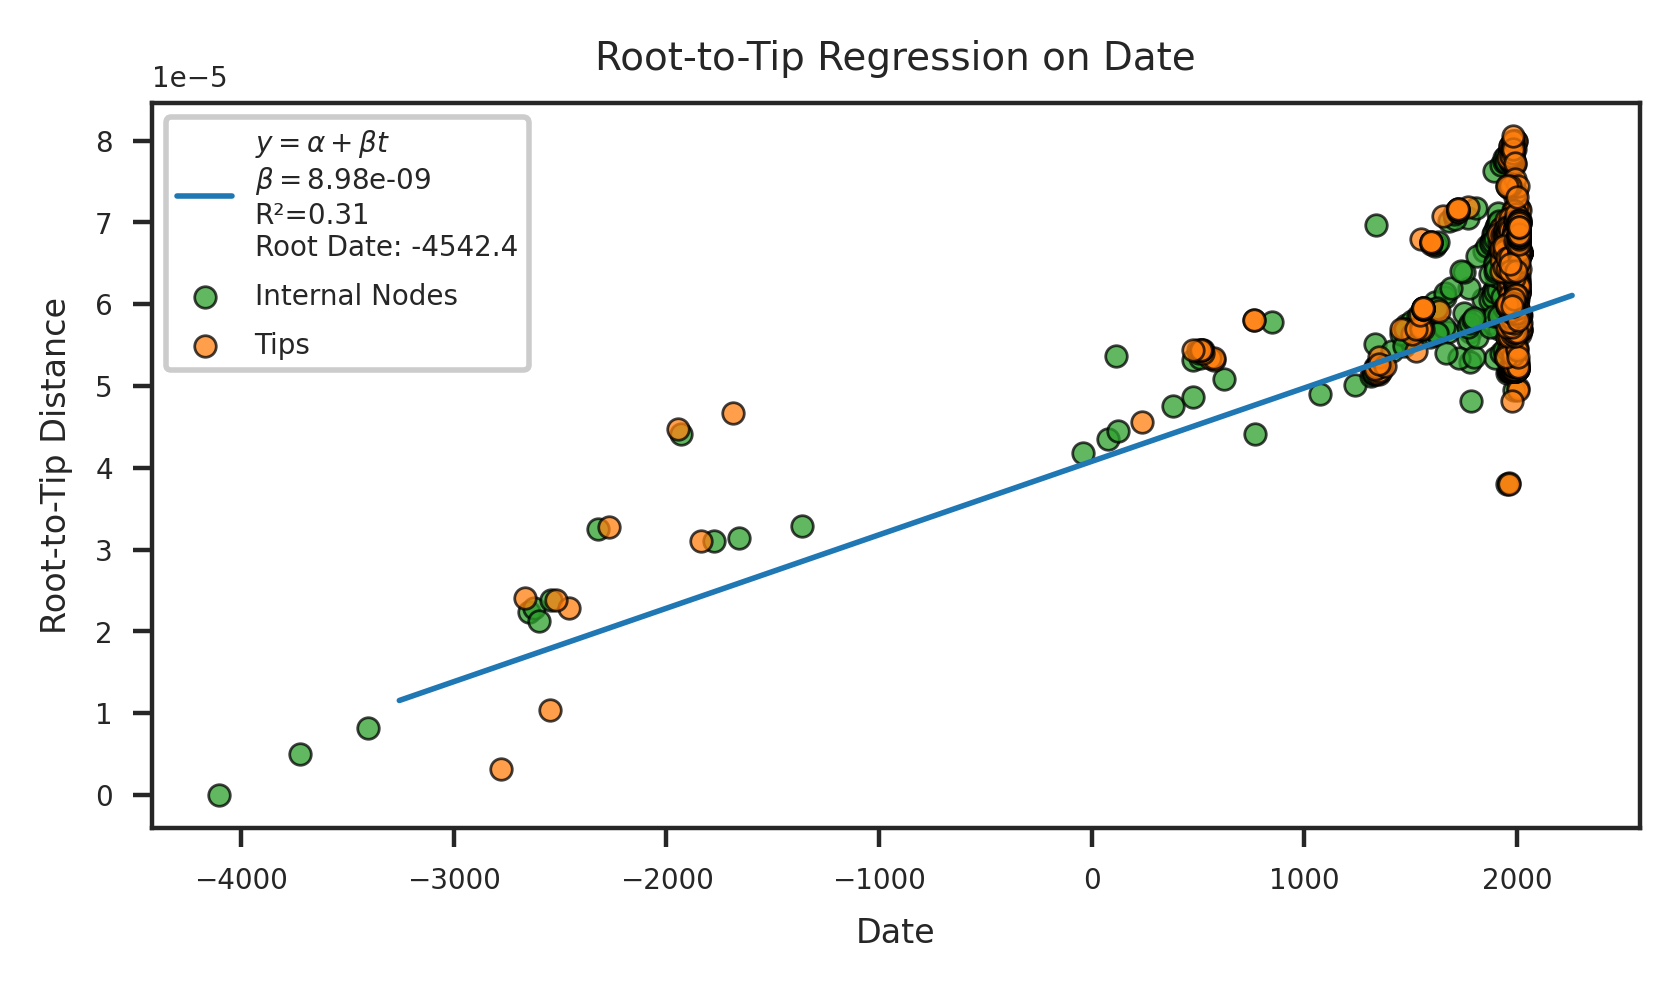

In [350]:
regression = tt.clock_model

# Setup axis
fig, (ax1) = plt.subplots(1, dpi=dpi, figsize=figsize_mini)


# Make separate datasets for tips and internal nodes
tip_data = tree_df[(tree_df["timetree_reg_x"] != NO_DATA_CHAR) &
                   (tree_df["Branch_Support_Color"] == TERM_COL) ]

int_data = tree_df[(tree_df["timetree_reg_x"] != NO_DATA_CHAR) & (tree_df["Branch_Support_Color"] != TERM_COL)]

# Time to most recent common ancestor (x-intercept)
t_mrca = -regression['intercept']/regression['slope']

# This does not filter for bad branches!
time_span = np.max(tip_data["timetree_reg_x"]) - np.min(tip_data["timetree_reg_x"])
x_vals = np.array([max(np.min(tip_data["timetree_reg_x"]), t_mrca) - 0.1*time_span, 
                   np.max(tip_data["timetree_reg_x"]+0.05*time_span)])
res = scipy.stats.linregress(list(tip_data["timetree_reg_x"]),list(tip_data["timetree_reg_y"]))

# When no confidence is enabled
dev_rtt = None
dev_slope = None

# Plot internal nodes
ax1.scatter(data=int_data, 
            x="timetree_reg_x", 
            y="timetree_reg_y",
            label="Internal Nodes",
            color=DISC_CMAPLIST[2],
            edgecolor="black",
            linewidth=0.5,
            s=15,
            alpha=0.75,
            zorder=1,)
# Plot tips
ax1.scatter(data=tip_data, 
            x="timetree_reg_x", 
            y="timetree_reg_y",
            label="Tips",
            color=DISC_CMAPLIST[1],
            edgecolor="black",
            linewidth=0.5,
            s=15,
            alpha=0.75,
            zorder=2,)

# Regression line
ax1.plot(x_vals, 
         regression['slope']*x_vals + regression['intercept'],
         label = r"$y=\alpha + \beta t$"+"\n"+
                r"$\beta=$%1.2e"%(regression["slope"])
                + ("+/- %1.e"%dev_slope if dev_slope else "") +
                "\nR²={:.2f}".format(res.rvalue**2) +
                "\nRoot Date: %1.1f"%(-regression['intercept']/regression['slope']) +
                ("+/- %1.2f"%dev_rtt if dev_rtt else ""),
         color=DISC_CMAPLIST[0],
         zorder=3,
         lw=1,
        )

# Labels
ax1.set_xlabel("Date", fontsize=6)
ax1.set_ylabel("Root-to-Tip Distance", fontsize=6)
ax1.set_title("Root-to-Tip Regression on Date", fontsize=7)
# Legend
#plt.legend(loc=2, frameon = 1, framealpha=1)
plt.legend(bbox_to_anchor=(0,1.00), 
           loc="upper left",
           frameon = 1, 
           framealpha=1)

# Save
out_path = os.path.join(outdir, SCRIPT_NAME + "_rtt." + FMT) 
plt.savefig(out_path, 
            dpi=dpi, 
            bbox_inches = "tight")

---
# 2. Plot Rate Variation: Histogram

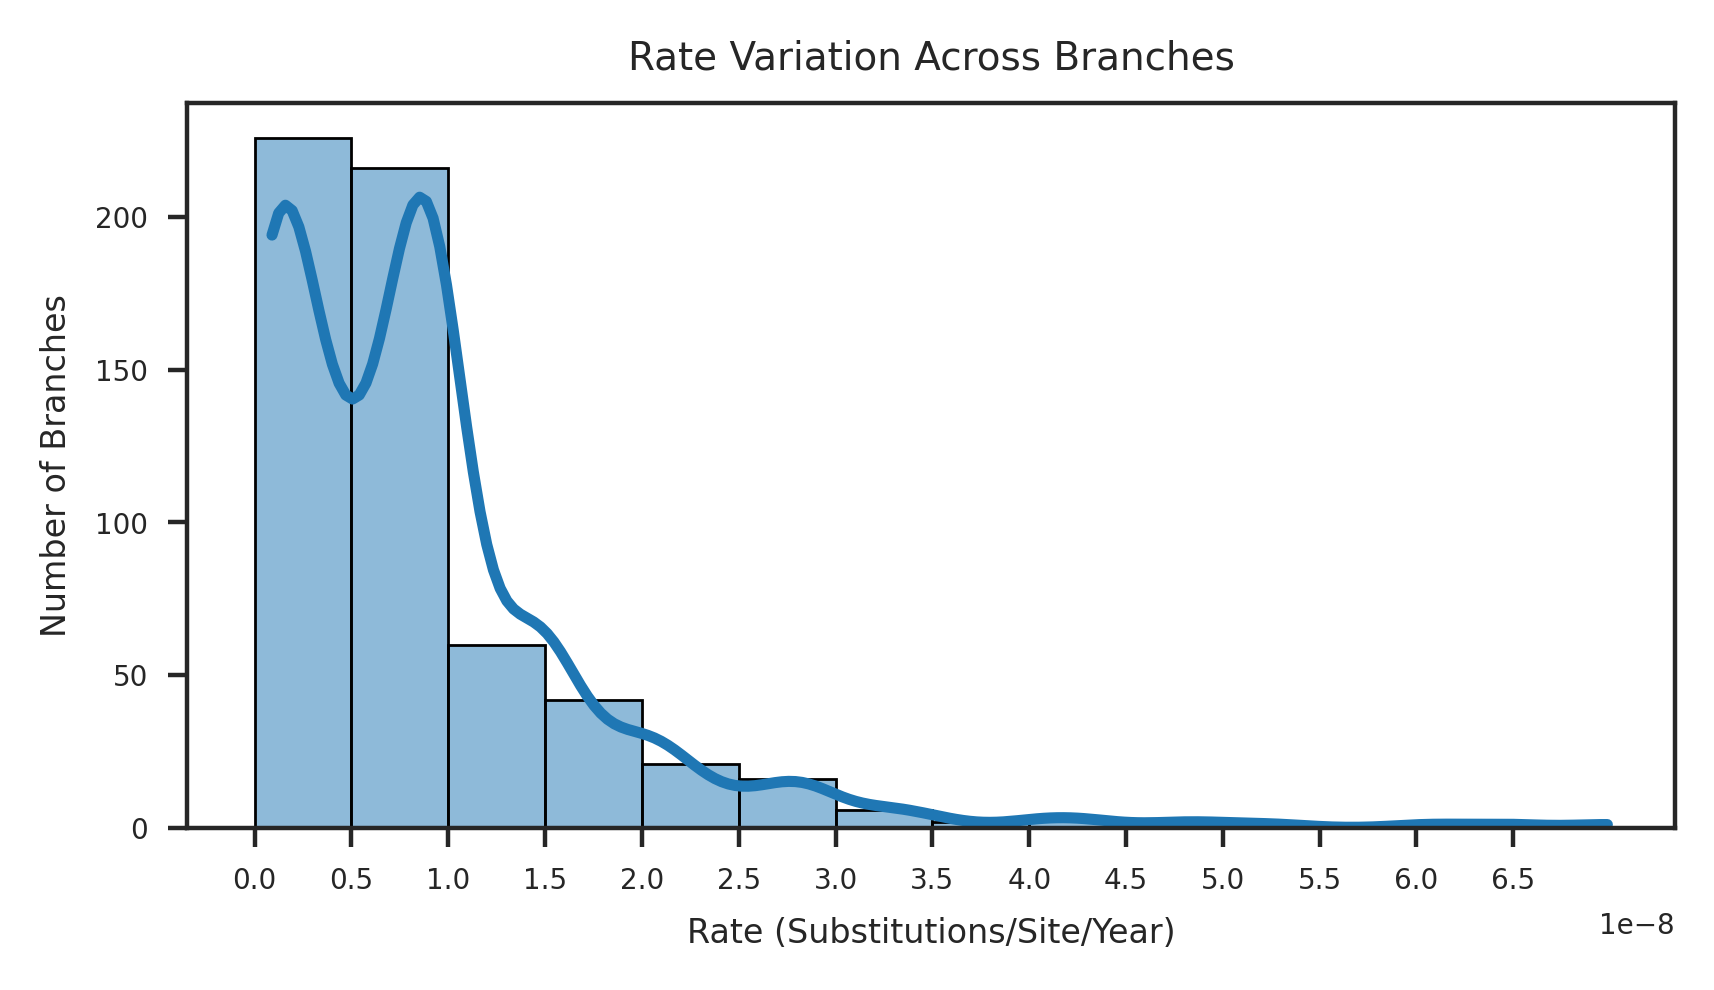

In [348]:
# Setup axis
fig, ax1 = plt.subplots(1, dpi=dpi, figsize=figsize_mini)

# Plot the rate histogram
mean_rate = sum(tip_data["timetree_rate"]) / len(tip_data["timetree_rate"])
max_rate = max(tip_data["timetree_rate"])

# If marginal and a relaxed clock used
if mean_rate != max_rate:
    hist_bins = [x/1000000000 for x in range(0,int(max_rate * 1000000000), 5)]
    xticks = hist_bins
else:
    hist_bins = 1
    
    xticks = [mean_rate]
    
sns.histplot(
    x = list(tip_data["timetree_rate"]), 
    ax=ax1, 
    kde=True,
    bins=hist_bins,
    kde_kws={'bw_adjust':0.75,},
    ec="black",
    linewidth=0.5,
)

ax1.set_xticks(xticks)

ax1.set_xlabel("Rate (Substitutions/Site/Year)", fontsize=6)
ax1.set_ylabel("Number of Branches", fontsize=6)
ax1.set_title("Rate Variation Across Branches", fontsize=7)


# Save
out_path = os.path.join(outdir, SCRIPT_NAME + "_rate-variation." + FMT) 
plt.savefig(out_path, 
        dpi=dpi, 
        bbox_inches = "tight")

---
# 3. Plot Root Marginal Date Distribution

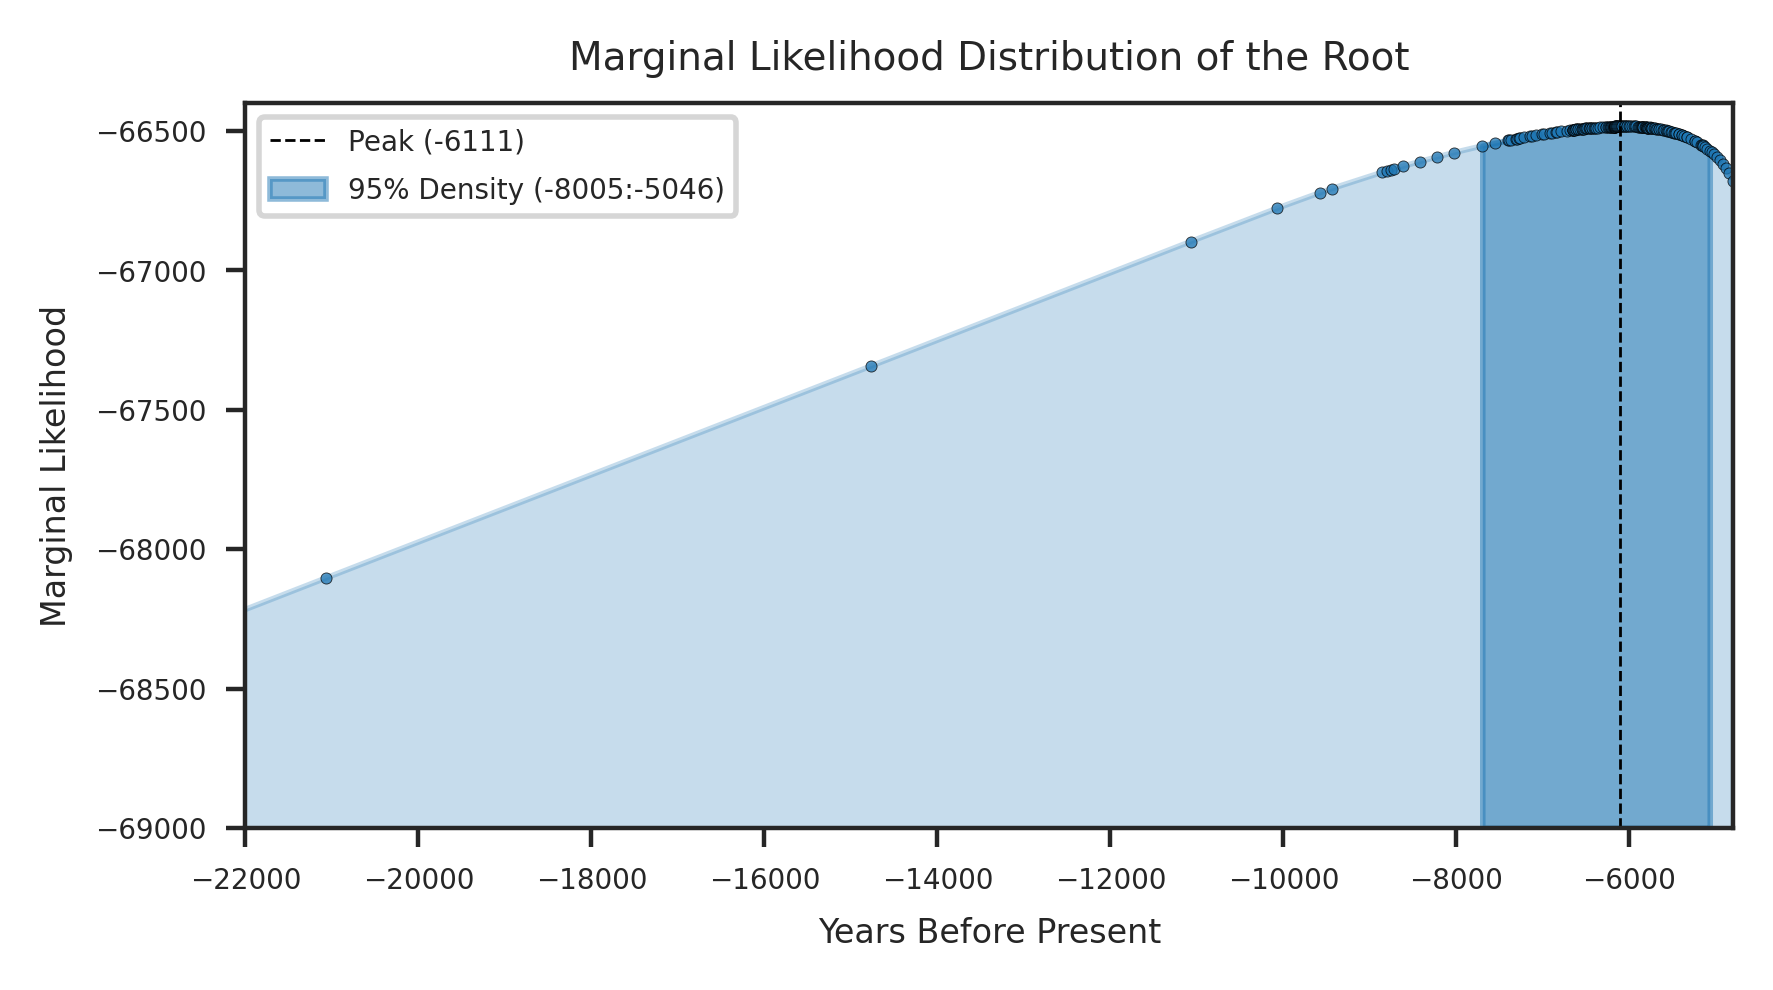

In [347]:
# Prep Data
marg = tt.tree.root.marginal_pos_LH
marg_x = [tt.date2dist.to_numdate(x) for x in marg.x]
marg_x = [x - CURRENT_YEAR for x in marg_x]
marg_y = [-y for y in list(marg.y)]
marg_peak = tt.date2dist.to_numdate(marg.peak_pos) - CURRENT_YEAR

conf = tt.get_max_posterior_region(tt.tree.root, fraction=1.0)
conf = [c - CURRENT_YEAR for c in conf]
   
# Adjust
#marg_x = marg_x[:-25]
#marg_y = [ -y for y in marg_y[:-25]]

     
# Fit a spline to the values
marg_x.reverse()
marg_y.reverse()
marg_s = UnivariateSpline(marg_x, marg_y)
marg_ys = s(marg_x)

# Get the x,y values associated with confidence range
conf_x = []
conf_y = []
for x,y in zip(marg_x, marg_y):
    if x >= conf[0] and x <= conf[1]:
        conf_x.append(x)
        conf_y.append(y) 

# Fit a spline to the confidence range
conf_s = UnivariateSpline(conf_x, conf_y)
conf_ys = s(conf_x)

fig, ax1 = plt.subplots(1, dpi=dpi, figsize=figsize_mini)
sns.scatterplot(x=marg_x, y=marg_y, ec="black", alpha=0.75, axes=ax1, s=4, fc="#1F77B4", zorder=2)

# CUSTOMIZE THE RANGES BASED ON RUN
ax1.set_xlim(-22000,max(marg_x))
ax1.set_ylim(-69000,-66400)

ax1.fill_between(marg_x, marg_ys, -70000, zorder=1, color="#1F77B4", alpha=0.25)
ax1.fill_between(
    conf_x, conf_ys, ax1.get_yticks()[0], 
    zorder=1, 
    color="#1F77B4", alpha=0.50, 
    label="{}% Density ({}:{})".format(int(CONFIDENCE* 100), int(conf[0]), int(conf[1])))

ax1.axvline(x=marg_peak, color="black", linestyle="--", lw=0.5, label="Peak ({})".format(int(marg_peak)))
#ax1.axvline(x=conf[0], c="#1F77B4", lw=1)
#ax1.axvline(x=conf[1], c="#1F77B4", lw=1)
ax1.set_title("Marginal Likelihood Distribution of the Root", fontsize=7)
ax1.set_ylabel("Marginal Likelihood", fontsize=6)
ax1.set_xlabel("Years Before Present", fontsize=6)


plt.legend(frameon=True)

# Save
out_path = os.path.join(outdir, SCRIPT_NAME + "_root-marginal." + FMT) 
plt.savefig(out_path, 
            dpi=dpi, 
            bbox_inches = "tight")

In [77]:
float('-20000')

-20000.0

## ? Plot Marginal Estimate Comparison

In [ ]:
# How many 95% marginal ranges do not contain the joint date?

res_lower_list = []
res_upper_list = []

if hasattr(tt_copy.tree.root, "marginal_inverse_cdf"):
    for c in tt_copy.tree.find_clades():
        conf = tt.get_max_posterior_region(c, fraction=CONFIDENCE)
        
        # Check if marginal doesn't contain joint date
        res_lower_list.append(c.numdate - conf[0])
        res_upper_list.append(conf[1] - c.numdate)

residuals = res_lower_list + res_upper_list
labels = ["Lower" for r in res_lower_list] + ["Upper" for r in res_upper_list]
res_marginal_df = pd.DataFrame(zip(residuals, labels), columns=["Residual", "Type"])
display(res_marginal_df)

In [ ]:
# Setup axis
fig, ax1 = plt.subplots(1, dpi=200, tight_layout=True)

flierprops = dict(marker='o', markersize=1)

sns.violinplot(data=res_marginal_df, x="Type", y="Residual", ax=ax1, width=0.5)
sns.boxplot(data=res_marginal_df, 
            x="Type", 
            y="Residual", 
            showfliers=True, 
            showbox=False, 
            whis=[2.5,97.5], 
            flierprops=flierprops)
ax1.suptitle("Marginal Date Residuals Compared to Joint Date", fontsize=6)

## ? Plot Marginal Date Ranges

In [ ]:
# Plot date range by date

if hasattr(tt_copy.tree.root, "marginal_inverse_cdf"):
    dates = []
    ranges = []
    types = []
    
    for c in tt_copy.tree.find_clades():
        sample_type = "Internal"
        if c.is_terminal():
            sample_type = "Tip"
        conf = tt.get_max_posterior_region(c, fraction=CONFIDENCE)
        conf_range = conf[1] - conf[0]
        ranges.append(conf_range)
        dates.append(c.numdate)
        types.append(sample_type)

date_range_df = pd.DataFrame(zip(dates, ranges, types), columns=["Date", "Range", "Type"])
display(date_range_df)

In [ ]:
fig, ax1 = plt.subplots(1, dpi=200, figsize=(4,2), tight_layout=True)

sns.scatterplot(data=date_range_df, x="Date", y="Range", hue="Type", axes=ax1, ec="black", alpha=0.75, s=10)
ax1.set_ylabel("Date Range (years)", fontsize=5)
ax1.set_xlabel("Date", fontsize=5)
ax1.set_title("Relationship between Estimated Date and Date Range", fontsize=5)

In [ ]:
fig, ax1 = plt.subplots(1, dpi=200, figsize=(4,2), tight_layout=True)

sns.violinplot(data=date_range_df, x="Type", y="Range", ax=ax1)
ax1.set_xlabel("Node Type", fontsize=5)
ax1.set_ylabel("Date Range (years)", fontsize=5)

In [ ]:
fig_dates = plt.figure(figsize=(8,4), dpi=dpi)

gs = gridspec.GridSpec(2, 2, figure=fig_dates, wspace=0, hspace=0)
ax1 = fig_dates.add_subplot(gs[0, 0], )
ax2 = fig_dates.add_subplot(gs[0, 1], )
ax3 = fig_dates.add_subplot(gs[1, 0], )
ax4 = fig_dates.add_subplot(gs[1, 1], )

flierprops = dict(marker='o', markersize=1)
sns.violinplot(data=date_range_df, x="Type", y="Range", ax=ax1)
ax1.set_xlabel("Node Type")
ax1.set_ylabel("Date Range (years)")

sns.scatterplot(data=date_range_df, x="Date", y="Range", hue="Type", ax=ax2, ec="black", alpha=0.75, s=10)
ax2.set_ylabel("")
ax2.set_yticks([])
ax2.set_xlabel("Date",)

flierprops = dict(marker='o', markersize=1)

sns.violinplot(data=res_marginal_df, x="Type", y="Residual", ax=ax3, width=0.5)
sns.boxplot(data=res_marginal_df, 
            ax=ax3,
            x="Type", 
            y="Residual", 
            showfliers=True, 
            showbox=False, 
            whis=[2.5,97.5], 
            flierprops=flierprops)



# 3. Plot Timetree: Phylo

In [ ]:
# Make a copy to change branch_length
tt_copy = copy.deepcopy(tt)
tt_copy.branch_length_to_years()

In [ ]:
if hasattr(tt_copy.tree.root, "marginal_inverse_cdf"):
    CONF_BAD_RANGE = 10000
    CONF_EXTREME = 100000

    bad_conf = [["node", "lower_bad", "upper_bad", "lower_corrected", "upper_corrected"]]
    for c in tt_copy.tree.find_clades():
        conf = tt.get_max_posterior_region(c, fraction=CONFIDENCE)
        
        # Check if marginal doesn't contain joint date
        if c.numdate < (conf[0] - 10) or c.numdate > (conf[1] + 10):
            print(c.name, "\t", conf[0], "\t", c.numdate, "\t", conf[1])
            
            
        conf_range = abs(conf[1] - conf[0])
        if conf_range > CONF_BAD_RANGE or conf[0] < -CONF_EXTREME or conf[1] > CONF_EXTREME:
            print("Bad confidence estimated for:", c.name,"\t", conf_range, "\t", conf[0], "\t", conf[1], "\tSetting to", c.numdate)       
            tree_df.at[c.name, "timetree_num_date_bar"] = [c.numdate, c.numdate]
            bad_conf.append([c.name, conf[0], conf[1], c.numdate, c.numdate])

    out_path_bad_conf = os.path.join(outdir, SCRIPT_NAME + "_bad-confidence.tsv")
    with open(out_path_bad_conf, "w") as outfile:
        for node in bad_conf:
            outfile.write("\t".join([str(n) for n in node]) + "\n")

## Setup Up Figure and Axes

In [ ]:
axes_dict = {
    "Tree" : {
        "prop" : 20,
        "title" : "Time Tree",
        "xlabel" : "Year",
        "key" : "Tree",
        "i" : 0,
        "xmax"   : 0,       
    },
    "Clade" : {
        "prop" : 1,
        "title" : "Clade",
        "xlabel" : "",        
        "key" : "Clade",
        "i" : 1,  
        "xmax"   : 0,        
    },   
}

fig_timetree = plt.figure(figsize=(12,8), dpi=dpi)

total_col = sum([axes_dict[ax]["prop"] for ax in axes_dict])
gs = gridspec.GridSpec(1, total_col, figure=fig_timetree, wspace=0.25, hspace=0)

axes = []
i_ax = 0
i_prev = 0
for ax in axes_dict:
    i_cur = i_prev + axes_dict[ax]["prop"]
    if len(axes) > 0:
        axes += [fig_timetree.add_subplot(gs[0, i_prev:i_cur], sharey=axes[0])]
    else:
        axes += [fig_timetree.add_subplot(gs[0, i_prev:i_cur],)]
    i_prev = i_cur
    axes[i_ax].set_title(axes_dict[ax]["title"], fontsize=8)
    
    # Spines
    for s in axes[i_ax].spines:
        axes[i_ax].spines[s].set_linewidth(0.5)
    axes[i_ax].spines["right"].set_visible(False)
    axes[i_ax].spines["top"].set_visible(False)
    axes[i_ax].spines["left"].set_visible(False)  
    
    # X-Axis
    if i_ax != 0:
        axes[i_ax].set_xticks([0, axes_dict[ax]["xmax"]])
        axes[i_ax].set_xticklabels([""] + [str(axes_dict[ax]["xmax"])])
        axes[i_ax].set_xlabel(axes_dict[ax]["xlabel"], fontsize=6)
    # Y-Axis
    axes[i_ax].set_yticks([])
        
    i_ax += 1
    
ax_tree = axes[0]
ax_clade = axes[1]

# --------------------------------------------
# Ticks
ticks_dict = convert_timetree_ticks(tree=tt_copy.tree, step=500)
# Set the new tick locations and labels
ax_tree.set_xticks(ticks_dict["tick_locs"])
ax_tree.set_xticklabels(ticks_dict["tick_labels"])
date_to_x = float(ticks_dict["tick_locs"][-1]) - float(ticks_dict["tick_labels"][-1])

# --------------------------------------------
# Lines
# Vertical lines for dates
for loc in ticks_dict["tick_locs"]:
    ax_tree.axvline(x=loc, color="darkgrey", alpha=0.5, lw=0.50)

# --------------------------------------------
# Limits
x_buffer = math.ceil((ticks_dict["tick_locs"][-1] - ticks_dict["tick_locs"][0]) * 0.05)
y_buffer = math.ceil(len(tt_copy.tree.get_terminals()) * 0.05)

x_min = 0
ax_tree.set_xlim(x_min - x_buffer - x_buffer, ticks_dict["tick_locs"][-1] + x_buffer)
ax_tree.set_ylim(len(tt_copy.tree.get_terminals()) + y_buffer, 0 - y_buffer)

# --------------------------------------------
# Misc
ax_tree.spines["right"].set_visible(False)
ax_tree.spines["top"].set_visible(False)
ax_tree.spines["left"].set_visible(False)

## Add Clade Colors

In [ ]:
tip_data = tree_df[(tree_df["Branch_Support_Color"] == TERM_COL)]
#axes[0].scatter(data=tip_data, x="timetree_coord_x", y="timetree_coord_y", s=0.5, c="grey")

for rec in tip_data.iterrows():
    y = rec[1]["timetree_coord_y"]
    state = rec[1]["Branch_Major"]
    color = colors_dict["branch_major"][state]
    ax_clade.plot([0, 1], [y,y], alpha=1, c=color, linewidth=1)

ax_clade.set_xticks([])
ax_clade.spines["bottom"].set_visible(False) 

fig_timetree

## Add Legend

In [ ]:
clade_lines = [lines.Line2D([0], [0], color=colors_dict["branch_major"][state], lw=4) 
                for state in colors_dict["branch_major"]]
clade_labels = [state for state in colors_dict["branch_major"]]

clade_legend = fig_timetree.legend(clade_lines, 
           clade_labels,
           ncol=len(clade_labels),
           loc="center", 
           bbox_to_anchor=(0.5, 0),
           #bbox_to_anchor=(0.14,-0.13),
           frameon=True,
           borderpad=1.0,
           edgecolor="black",
           title="Clade",
           title_fontsize=10,
           fontsize=8,
          )

fig_timetree

## Add Confidence Bars

In [ ]:
# --------------------------------------------
# Confidence Bars
x_min = 0
if hasattr(tt_copy.tree.root, "marginal_inverse_cdf"):
    # Need to invert the node bar units
    present_date = abs(tt_copy.tree.root.numdate - CURRENT_YEAR)
    for rec in tree_df.iterrows():
        conf_bar = rec[1]["timetree_num_date_bar"]
        bar_lower = present_date - conf_bar[0]
        bar_upper = present_date - conf_bar[1]
        y = rec[1]["timetree_coord_y"]
        ax_tree.plot([bar_lower, bar_upper], [y,y], alpha=0.25, c="blue", linewidth=2)
        
        # Possibly update axis x-limits
        if bar_lower < x_min:
            x_min = bar_lower
            
fig_timetree

## Add Phylogeny

In [ ]:
# --------------------------------------------
# Setup
plt.rc("lines", linewidth=0.25)

# --------------------------------------------
# Data
tt_copy.branch_length_to_years()

# reset color
for c in tt_copy.tree.find_clades():
    c.color = "black"
    
plt.rc("lines", linewidth=0.5)
Phylo.draw(tt_copy.tree,
           axes=axes[0], 
           show_confidence=False, 
           label_func = lambda x:'', 
           #label_func = lambda x : tree_df["Branch_Major"][x.name],
          )

# --------------------------------------------
# Labels
ax_tree.set_xlabel("Year")
ax_tree.set_ylabel("")
ax_tree.set_yticks([])


# --------------------------------------------
# Limits (again)        
ax_tree.set_xlim(x_min - x_buffer - x_buffer, ticks_dict["tick_locs"][-1] + x_buffer)
ax_tree.set_ylim(len(tt_copy.tree.get_terminals()) + y_buffer, 0 - y_buffer)

fig_timetree

## Save

In [ ]:
out_path = os.path.join(outdir, SCRIPT_NAME + "_timetree." + FMT)
fig_timetree.savefig(out_path, dpi=dpi, bbox_inches = "tight")
out_path = os.path.join(outdir, SCRIPT_NAME + "_timetree." + "jpg")
fig_timetree.savefig(out_path, dpi=dpi, bbox_inches = "tight")

# 4. Plot Rate Variation

In [ ]:
"""# Set branch length to mutations
for n in tt_copy.tree.find_clades():
    n.branch_length=n.mutation_length
    
min_gamma = min(tree_df["timetree_rate_fold_change"])
max_gamma = max(tree_df["timetree_rate_fold_change"])
gamma_range = max_gamma - min_gamma

GAMMA_COL_PAL = {
    0: "#000000", # black
    1: "#facb35", # yellow
    2: "#ff8800", # orange
    3: "#ff0000"} # red

for c in tt_copy.tree.find_clades():
    if not hasattr(c.branch_length_interpolator, "gamma"):
        c.color = GAMMA_COL_PAL[0]
        continue
    gamma = c.branch_length_interpolator.gamma
    # Switch Case
    if gamma >= 0 and gamma < 1:
        c.color = GAMMA_COL_PAL[0]
    elif gamma >= 1 and gamma < 2:
        c.color = GAMMA_COL_PAL[1]    
    elif gamma >= 2 and gamma < 3:
        c.color = GAMMA_COL_PAL[2]     
    elif gamma >= 3:
        c.color = GAMMA_COL_PAL[3] 

# Setup plot
plt.rc("lines", linewidth=1)
fig, ax1 = plt.subplots(1, dpi=dpi, figsize=figsize, constrained_layout=True,)

Phylo.draw(tt_copy.tree,
           axes=ax1, 
           show_confidence=False, 
           label_func = lambda x:'', 
           do_show=False)

# --------------------------------------------
# Lines
# Vertical lines for dates
for loc in ticks_dict["tick_locs"]:
    ax1.axvline(x=loc, color="darkgrey", alpha=0.5)

# --------------------------------------------
# Labels
ax1.set_xlabel("Branch Length")
ax1.set_ylabel("")
ax1.set_yticks([])
plt.title("Divergence Tree")

# --------------------------------------------
# Limits
coord_x = [x for x in tree_df["coord_x"] if x != NO_DATA_CHAR]
x_buffer = max(coord_x) * 0.05
y_buffer = math.ceil(len(tt_copy.tree.get_terminals()) * 0.01)

ax1.set_xlim(0 - x_buffer, max(coord_x) + x_buffer)
ax1.set_ylim(len(tt_copy.tree.get_terminals()) + y_buffer, 0 - y_buffer)

# --------------------------------------------
# Misc
ax1.spines["right"].set_visible(False)
ax1.spines["top"].set_visible(False)
ax1.spines["left"].set_visible(False)

# Save
out_path = os.path.join(outdir, SCRIPT_NAME + "_divtree-rate." + FMT) 
plt.savefig(out_path, dpi=dpi, bbox_inches = "tight")"""